In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
# This is need so you can import larndsim without doing python setup.py install
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

In [3]:
import matplotlib.pyplot as plt
from matplotlib import cm, colors
import mpl_toolkits.mplot3d.art3d as art3d

import numpy as np
import eagerpy as ep
import h5py

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100

In [4]:
from numpy.lib import recfunctions as rfn
import torch

def torch_from_structured(tracks):
    tracks_np = rfn.structured_to_unstructured(tracks, copy=True, dtype=np.float32)
    return torch.from_numpy(tracks_np).float()

def structered_from_torch(tracks_torch, dtype):
    return rfn.unstructured_to_structured(tracks_torch.cpu().numpy(), dtype=dtype)

### Dataset import
First of all we load the `edep-sim` output. For this sample we need to invert $z$ and $y$ axes.

In [5]:
# If you have access to a GPU, sim works trivially/is much faster
if torch.cuda.is_available():
    device = 'cuda'
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    device = 'cpu'

In [6]:
with h5py.File('module0_corsika.h5', 'r') as f:
    tracks = np.array(f['segments'])

x_start = np.copy(tracks['x_start'] )
x_end = np.copy(tracks['x_end'])
x = np.copy(tracks['x'])

tracks['x_start'] = np.copy(tracks['z_start'])
tracks['x_end'] = np.copy(tracks['z_end'])
tracks['x'] = np.copy(tracks['z'])

tracks['z_start'] = x_start
tracks['z_end'] = x_end
tracks['z'] = x

selected_tracks = tracks[30:40]
selected_tracks_torch = torch_from_structured(np.copy(selected_tracks)).to(device)

## Simulation
To flexibly keep track of parameters/gradients, simulations are housed in a class `sim_with_grad`. This is derived from class versions of all the other modules. Parameters are housed in `consts`, with method `track_gradients` to promote the constants to `requires_grad=True` PyTorch tensors.

In [7]:
from larndsim.sim_with_grad import sim_with_grad

Generate <class 'larpix.configuration.configuration_v2b.Configuration_v2b'>.pixel_trim_dac using bits (0, 512)
	<function _list_property at 0x7f3e08af9820>((<class 'int'>, 0, 31, 64, 8)) 
Generate <class 'larpix.configuration.configuration_v2b.Configuration_v2b'>.threshold_global using bits (512, 520)
	<function _basic_property at 0x7f3e08af9790>((<class 'int'>, 0, 255)) 
Generate <class 'larpix.configuration.configuration_v2b.Configuration_v2b'>.csa_gain using bits (520, 521)
	<function _compound_property at 0x7f3e08af98b0>((['csa_gain', 'csa_bypass_enable', 'bypass_caps_en'], (<class 'int'>, <class 'bool'>), 0, 1)) 
Generate <class 'larpix.configuration.configuration_v2b.Configuration_v2b'>.csa_bypass_enable using bits (521, 522)
	<function _compound_property at 0x7f3e08af98b0>((['csa_gain', 'csa_bypass_enable', 'bypass_caps_en'], (<class 'int'>, <class 'bool'>), 0, 1)) 
Generate <class 'larpix.configuration.configuration_v2b.Configuration_v2b'>.bypass_caps_en using bits (522, 523)
	

## The simulation
Following the flow of the simulation chain, define a function which takes in the `sim_with_grad` object, runs whatever pieces of the simulation, and returns desired output.

In [8]:
# Here we build a map between tracks and event IDs (no param dependence, so np should be ok)
unique_eventIDs = np.unique(selected_tracks['eventID'])
event_id_map = np.searchsorted(unique_eventIDs,np.asarray(selected_tracks['eventID']))
event_id_map_torch = torch.from_numpy(event_id_map).to(device)

/sdf/home/s/sgaz/conda/envs/ml/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
def all_sim(sim, selected_tracks, fields, event_id_map, return_unique_pix=False):
    selected_tracks_quench = sim.quench(selected_tracks, sim.birks, fields=fields)
    selected_tracks_drift = sim.drift(selected_tracks_quench, fields=fields)

    active_pixels_torch, neighboring_pixels_torch, n_pixels_list_ep = sim.get_pixels(selected_tracks_drift,
                                                                                     fields=fields)

    track_starts_torch, max_length_torch = sim.time_intervals(event_id_map_torch, 
                                                              selected_tracks_drift, 
                                                              fields=fields)
    
    signals_ep = sim.tracks_current(neighboring_pixels_torch, selected_tracks_drift, 
                                          max_length_torch,
                                          fields=fields)

    unique_pix_torch = torch.empty((0, 2))
    pixels_signals_torch = torch.zeros((len(unique_pix_torch), len(sim.time_ticks)*5))

    shapes_torch = neighboring_pixels_torch.shape
    joined_torch = neighboring_pixels_torch.reshape(shapes_torch[0]*shapes_torch[1], 2)

    this_unique_pix_torch = torch.unique(joined_torch, dim=0)
    this_unique_pix_torch = this_unique_pix_torch[(this_unique_pix_torch[:,0] != -1) & (this_unique_pix_torch[:,1] != -1),:]
    unique_pix_torch = torch.cat((unique_pix_torch, this_unique_pix_torch),dim=0)

    this_pixels_signals_torch = torch.zeros((len(this_unique_pix_torch), len(sim.time_ticks)*5))
    pixels_signals_torch = torch.cat((pixels_signals_torch, this_pixels_signals_torch), dim=0)

    pixel_index_map_torch = torch.full((selected_tracks.shape[0], neighboring_pixels_torch.shape[1]), -1)
    compare_torch = (neighboring_pixels_torch[..., np.newaxis, :] == unique_pix_torch)

    indices_torch = torch.where(torch.logical_and(compare_torch[..., 0], compare_torch[...,1]))
    pixel_index_map_torch[indices_torch[0], indices_torch[1]] = indices_torch[2]
    
    pixels_signals_torch = sim.sum_pixel_signals(pixels_signals_torch,
                                                 signals_ep,
                                                track_starts_torch,
                                                pixel_index_map_torch)
    
    time_ticks_torch = torch.linspace(0, len(unique_eventIDs)*sim.time_interval[1]*3, pixels_signals_torch.shape[1]+1)

    integral_list_torch, adc_ticks_list_torch = sim.get_adc_values(pixels_signals_torch,
                                                                   time_ticks_torch,
                                                                   0)
    adc_list_torch = sim.digitize(integral_list_torch)

    if return_unique_pix:
        return adc_list_torch, unique_pix_torch
    else:
        return adc_list_torch

In [10]:
# Update parameters for training loop
def update_grad_param(sim, name, value):
    setattr(sim, name, value)
    sim.track_gradients([name])

In [11]:
# ADC counts given as list of pixels. Better for loss to embed this in the "full" pixel space
def embed_adc_list(sim, adc_list, unique_pix):
    zero_val = sim.digitize(torch.tensor(0)).item()
    new_list = torch.ones((sim.n_pixels[0], sim.n_pixels[1], adc_list.shape[1]))*zero_val

    plane_id = unique_pix[..., 0] // sim.n_pixels[0]
    unique_pix[..., 0] = unique_pix[..., 0] - sim.n_pixels[0] * plane_id

    new_list[unique_pix[:, 0].long(), unique_pix[:, 1].long(), :] = adc_list
    
    return new_list

## Experiment: pseudo-data
1. Construct dataset with one set of parameters
2. Initialize parameters to something else
3. See if we can recover default parameters

In [12]:
#Simulate with defaults: in particular, eField == 0.5
sim_default = sim_with_grad()
sim_default.load_detector_properties("../larndsim/detector_properties/module0.yaml",
                             "../larndsim/pixel_layouts/multi_tile_layout-2.2.16.yaml")
target, pix_target = all_sim(sim_default, selected_tracks_torch, selected_tracks.dtype.names, 
                             event_id_map_torch, return_unique_pix=True)

embed_target = embed_adc_list(sim_default, target, pix_target)

/sdf/home/s/sgaz/conda/envs/ml/lib/python3.8/site-packages/eagerpy/tensor/base.py:98: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  return type(self)(self.raw.__floordiv__(unwrap1(other)))
/sdf/home/s/sgaz/conda/envs/ml/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
<ipython-input-11-bf45e8c64373>:6: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It current

In [13]:
#Setup simulation object for training
sim = sim_with_grad()
sim.load_detector_properties("../larndsim/detector_properties/module0.yaml",
                             "../larndsim/pixel_layouts/multi_tile_layout-2.2.16.yaml")

In [14]:
#Simple MSE loss between target and output
loss_fn = torch.nn.MSELoss()

#Initialize eField to different value
eField_init = 0.1
update_grad_param(sim, "eField", eField_init)

# Should be smarter w/ lr, but for now eyeball given gradient
optimizer = torch.optim.SGD([sim.eField], lr=1, momentum=0.1)

training_step_eFields = []
training_step_ADC = []
losses = []

#Training loop
for epoch in range(800):
    optimizer.zero_grad()
    
    #Simulate with that parameter and get output
    output, pix_out = all_sim(sim, selected_tracks_torch, selected_tracks.dtype.names, event_id_map, 
                              return_unique_pix=True)
    
    embed_output = embed_adc_list(sim, output, pix_out)
    
    #Calc loss between simulated and target + backprop
    loss = loss_fn(embed_output, embed_target)
    loss.backward()
    
    
    optimizer.step()
    
    if epoch % 100 == 0:
        print(f"eField for epoch {epoch}, {sim.eField} [kV / cm]")
    training_step_eFields.append(sim.eField.cpu().detach().numpy().copy())
    training_step_ADC.append(embed_output.cpu().detach())
    losses.append(loss.cpu().detach())

<ipython-input-11-bf45e8c64373>:6: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  plane_id = unique_pix[..., 0] // sim.n_pixels[0]


eField for epoch 0, 0.20822176337242126 [kV / cm]
eField for epoch 100, 0.4583182632923126 [kV / cm]
eField for epoch 200, 0.4928051233291626 [kV / cm]
eField for epoch 300, 0.50905442237854 [kV / cm]
eField for epoch 400, 0.5160947442054749 [kV / cm]
eField for epoch 500, 0.5194403529167175 [kV / cm]
eField for epoch 600, 0.5206847786903381 [kV / cm]
eField for epoch 700, 0.5192288756370544 [kV / cm]


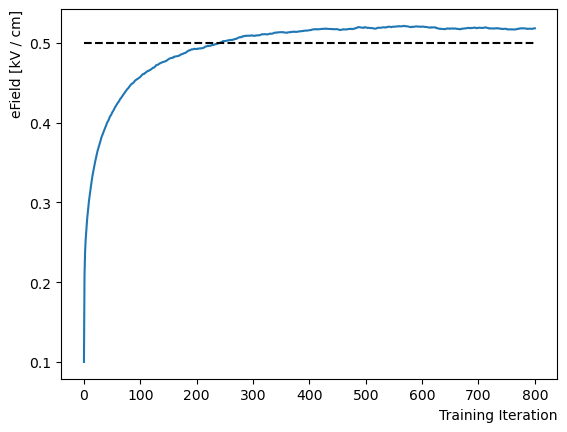

In [15]:
plt.plot([0.1]+training_step_eFields)
plt.plot([0.5]*(len(training_step_eFields)+1), ls='dashed', c='k')
plt.ylabel('eField [kV / cm]', ha='right', y=1.0)
plt.xlabel('Training Iteration', ha='right', x=1.0)
#plt.savefig('efield_convergence_ADC.pdf')
plt.show()

Final value is slightly high, but quite close (< 5% error). Likely comparable with true value within noise, to be checked.

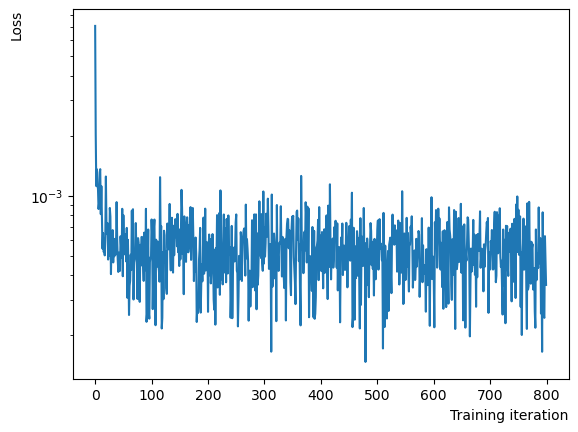

In [16]:
plt.plot(losses)
plt.yscale('log')
plt.xlabel('Training iteration', ha='right', x=1.0)
plt.ylabel('Loss', ha='right', y=1.0)
plt.show()

## Repeat 1 parameter fit for lifetime

In [17]:
#Simulate with defaults: in particular, lifetime == 2200
sim_default = sim_with_grad()
sim_default.load_detector_properties("../larndsim/detector_properties/module0.yaml",
                             "../larndsim/pixel_layouts/multi_tile_layout-2.2.16.yaml")
target, pix_target = all_sim(sim_default, selected_tracks_torch, selected_tracks.dtype.names, 
                             event_id_map_torch, return_unique_pix=True)

embed_target = embed_adc_list(sim_default, target, pix_target)

<ipython-input-11-bf45e8c64373>:6: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  plane_id = unique_pix[..., 0] // sim.n_pixels[0]


In [18]:
#Setup simulation object for training
sim = sim_with_grad()
sim.load_detector_properties("../larndsim/detector_properties/module0.yaml",
                             "../larndsim/pixel_layouts/multi_tile_layout-2.2.16.yaml")

In [19]:
#Simple MSE loss between target and output
loss_fn = torch.nn.MSELoss()

#Initialize lifetime to different value
lifetime_init = 100
update_grad_param(sim, "lifetime", lifetime_init)

# Should be smarter w/ lr, but for now eyeball given gradient
optimizer = torch.optim.SGD([sim.lifetime], lr=5e7, momentum=0.01)

training_step_lifetimes = []
training_step_ADC = []
losses = []

#Training loop
for epoch in range(1000):
    optimizer.zero_grad()
    
    #Simulate with that parameter and get output
    output, pix_out = all_sim(sim, selected_tracks_torch, selected_tracks.dtype.names, event_id_map, 
                              return_unique_pix=True)
    
    embed_output = embed_adc_list(sim, output, pix_out)
    
    #Calc loss between simulated and target + backprop
    loss = loss_fn(embed_output, embed_target)
    loss.backward()
    
    print(sim.lifetime)
    optimizer.step()
    print(sim.lifetime.grad)
    #if epoch % 100 == 0:
    #    print(f"Lifetime for epoch {epoch}, {sim.lifetime} $\\mu s$")
    training_step_lifetimes.append(sim.lifetime.cpu().detach().numpy().copy())
    training_step_ADC.append(embed_output.cpu().detach())
    losses.append(loss.cpu().detach())

<ipython-input-11-bf45e8c64373>:6: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  plane_id = unique_pix[..., 0] // sim.n_pixels[0]


tensor(100., requires_grad=True)
tensor(0.)
tensor(100., requires_grad=True)
tensor(0.)
tensor(100., requires_grad=True)
tensor(0.)
tensor(100., requires_grad=True)
tensor(0.)
tensor(100., requires_grad=True)
tensor(0.)
tensor(100., requires_grad=True)
tensor(0.)
tensor(100., requires_grad=True)
tensor(-5.9595e-06)
tensor(397.9765, requires_grad=True)
tensor(-3.1177e-05)
tensor(1959.8052, requires_grad=True)
tensor(-9.9670e-08)
tensor(1980.4070, requires_grad=True)
tensor(-5.0144e-08)
tensor(1983.1202, requires_grad=True)
tensor(-4.8381e-08)
tensor(1985.5664, requires_grad=True)
tensor(-5.1563e-08)
tensor(1988.1691, requires_grad=True)
tensor(-1.2262e-08)
tensor(1988.8082, requires_grad=True)
tensor(-1.0112e-07)
tensor(1993.8708, requires_grad=True)
tensor(-6.0662e-08)
tensor(1996.9546, requires_grad=True)
tensor(-2.3236e-08)
tensor(1998.1472, requires_grad=True)
tensor(-3.0818e-08)
tensor(1999.7001, requires_grad=True)
tensor(-4.9643e-08)
tensor(2002.1978, requires_grad=True)
tensor(-

tensor(2184.1704, requires_grad=True)
tensor(-4.2962e-08)
tensor(2186.3250, requires_grad=True)
tensor(-2.9602e-08)
tensor(2187.8267, requires_grad=True)
tensor(-5.6633e-09)
tensor(2188.1248, requires_grad=True)
tensor(1.6293e-08)
tensor(2187.3130, requires_grad=True)
tensor(4.9450e-09)
tensor(2187.0576, requires_grad=True)
tensor(4.4133e-09)
tensor(2186.8345, requires_grad=True)
tensor(-1.5432e-08)
tensor(2187.6038, requires_grad=True)
tensor(-4.8052e-08)
tensor(2190.0139, requires_grad=True)
tensor(-4.0188e-08)
tensor(2192.0474, requires_grad=True)
tensor(2.1527e-08)
tensor(2190.9915, requires_grad=True)
tensor(6.1006e-08)
tensor(2187.9307, requires_grad=True)
tensor(4.0475e-08)
tensor(2185.8762, requires_grad=True)
tensor(2.5476e-08)
tensor(2184.5818, requires_grad=True)
tensor(-5.3393e-08)
tensor(2187.2385, requires_grad=True)
tensor(2.8309e-08)
tensor(2185.8496, requires_grad=True)
tensor(-5.5159e-09)
tensor(2186.1116, requires_grad=True)
tensor(-4.4265e-08)
tensor(2188.3274, requ

tensor(2252.0667, requires_grad=True)
tensor(-4.8232e-09)
tensor(2252.3103, requires_grad=True)
tensor(9.4491e-09)
tensor(2251.8403, requires_grad=True)
tensor(-1.0289e-08)
tensor(2252.3501, requires_grad=True)
tensor(-9.8419e-09)
tensor(2252.8474, requires_grad=True)
tensor(2.6336e-09)
tensor(2252.7207, requires_grad=True)
tensor(2.6546e-09)
tensor(2252.5867, requires_grad=True)
tensor(-4.1759e-08)
tensor(2254.6733, requires_grad=True)
tensor(-2.4871e-08)
tensor(2255.9377, requires_grad=True)
tensor(8.7101e-09)
tensor(2255.5149, requires_grad=True)
tensor(-2.4133e-08)
tensor(2256.7173, requires_grad=True)
tensor(-4.1121e-09)
tensor(2256.9348, requires_grad=True)
tensor(4.1319e-09)
tensor(2256.7305, requires_grad=True)
tensor(5.5758e-09)
tensor(2256.4497, requires_grad=True)
tensor(3.1406e-08)
tensor(2254.8767, requires_grad=True)
tensor(2.7467e-08)
tensor(2253.4875, requires_grad=True)
tensor(4.7469e-08)
tensor(2251.1003, requires_grad=True)
tensor(5.0288e-09)
tensor(2250.8250, requir

tensor(2271.4077, requires_grad=True)
tensor(-1.1897e-08)
tensor(2271.9817, requires_grad=True)
tensor(3.0396e-08)
tensor(2270.4675, requires_grad=True)
tensor(-2.4888e-08)
tensor(2271.6968, requires_grad=True)
tensor(6.9853e-08)
tensor(2268.2163, requires_grad=True)
tensor(-3.0286e-08)
tensor(2269.6958, requires_grad=True)
tensor(-4.0930e-08)
tensor(2271.7571, requires_grad=True)
tensor(3.1694e-08)
tensor(2270.1931, requires_grad=True)
tensor(-1.5800e-08)
tensor(2270.9675, requires_grad=True)
tensor(2.0497e-09)
tensor(2270.8728, requires_grad=True)
tensor(-3.7983e-08)
tensor(2272.7710, requires_grad=True)
tensor(-1.7680e-08)
tensor(2273.6741, requires_grad=True)
tensor(-2.7218e-09)
tensor(2273.8191, requires_grad=True)
tensor(1.9276e-08)
tensor(2272.8567, requires_grad=True)
tensor(-2.0773e-08)
tensor(2273.8857, requires_grad=True)
tensor(5.2881e-08)
tensor(2271.2520, requires_grad=True)
tensor(1.3647e-08)
tensor(2270.5432, requires_grad=True)
tensor(2.7528e-08)
tensor(2269.1597, requ

tensor(2286.2842, requires_grad=True)
tensor(7.7757e-09)
tensor(2285.9006, requires_grad=True)
tensor(-3.8891e-08)
tensor(2287.8413, requires_grad=True)
tensor(4.6756e-09)
tensor(2287.6270, requires_grad=True)
tensor(3.5865e-08)
tensor(2285.8315, requires_grad=True)
tensor(2.4133e-08)
tensor(2284.6069, requires_grad=True)
tensor(-4.4104e-09)
tensor(2284.8152, requires_grad=True)
tensor(-2.0891e-08)
tensor(2285.8618, requires_grad=True)
tensor(2.5298e-08)
tensor(2284.6074, requires_grad=True)
tensor(-1.7976e-08)
tensor(2285.4937, requires_grad=True)
tensor(3.2536e-09)
tensor(2285.3398, requires_grad=True)
tensor(-5.8374e-09)
tensor(2285.6301, requires_grad=True)
tensor(-3.5136e-08)
tensor(2287.3899, requires_grad=True)
tensor(1.5745e-09)
tensor(2287.3289, requires_grad=True)
tensor(-2.6233e-08)
tensor(2288.6399, requires_grad=True)
tensor(2.4541e-08)
tensor(2287.4260, requires_grad=True)
tensor(5.5720e-09)
tensor(2287.1353, requires_grad=True)
tensor(2.6308e-09)
tensor(2287.0007, requir

tensor(2263.3206, requires_grad=True)
tensor(-4.1218e-08)
tensor(2265.3757, requires_grad=True)
tensor(6.2905e-09)
tensor(2265.0818, requires_grad=True)
tensor(-1.7346e-08)
tensor(2265.9460, requires_grad=True)
tensor(-9.5493e-11)
tensor(2265.9595, requires_grad=True)
tensor(1.5751e-08)
tensor(2265.1721, requires_grad=True)
tensor(-9.9231e-09)
tensor(2265.6604, requires_grad=True)
tensor(4.2056e-08)
tensor(2263.5625, requires_grad=True)
tensor(3.9515e-08)
tensor(2261.5657, requires_grad=True)
tensor(-4.5532e-09)
tensor(2261.7734, requires_grad=True)
tensor(-1.5004e-09)
tensor(2261.8506, requires_grad=True)
tensor(3.8622e-08)
tensor(2259.9202, requires_grad=True)
tensor(-3.1528e-08)
tensor(2261.4773, requires_grad=True)
tensor(-4.2257e-08)
tensor(2263.6057, requires_grad=True)
tensor(4.1937e-08)
tensor(2261.5300, requires_grad=True)
tensor(-7.6758e-09)
tensor(2261.8931, requires_grad=True)
tensor(-3.0080e-08)
tensor(2263.4006, requires_grad=True)
tensor(-8.2368e-09)
tensor(2263.8276, re

tensor(2261.7505, requires_grad=True)
tensor(2.0031e-08)
tensor(2260.7249, requires_grad=True)
tensor(1.0077e-08)
tensor(2260.2107, requires_grad=True)
tensor(-6.2810e-08)
tensor(2263.3462, requires_grad=True)
tensor(-3.0524e-08)
tensor(2264.9038, requires_grad=True)
tensor(-4.6141e-08)
tensor(2267.2263, requires_grad=True)
tensor(1.3710e-09)
tensor(2267.1809, requires_grad=True)
tensor(-1.9483e-08)
tensor(2268.1545, requires_grad=True)
tensor(-1.4372e-08)
tensor(2268.8828, requires_grad=True)
tensor(-5.9119e-09)
tensor(2269.1858, requires_grad=True)
tensor(2.0271e-08)
tensor(2268.1753, requires_grad=True)
tensor(1.5804e-08)
tensor(2267.3750, requires_grad=True)
tensor(-3.1042e-08)
tensor(2268.9192, requires_grad=True)
tensor(-7.5482e-08)
tensor(2272.7087, requires_grad=True)
tensor(-1.3791e-08)
tensor(2273.4363, requires_grad=True)
tensor(-5.8488e-08)
tensor(2276.3679, requires_grad=True)
tensor(3.8336e-08)
tensor(2274.4805, requires_grad=True)
tensor(-9.8627e-09)
tensor(2274.9548, re

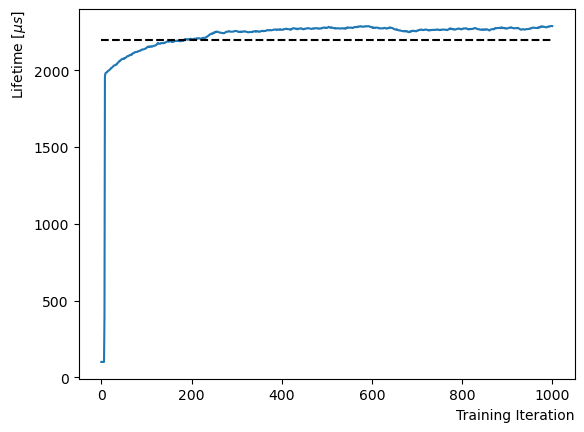

In [20]:
plt.plot([100]+training_step_lifetimes)
plt.plot([2200]*(len(training_step_lifetimes)+1), ls='dashed', c='k')
plt.ylabel('Lifetime [$\\mu s$]', ha='right', y=1.0)
plt.xlabel('Training Iteration', ha='right', x=1.0)
#plt.savefig('efield_convergence_ADC.pdf')
plt.show()

Final value is again slightly high, but quite close (< 5% error). Likely comparable with true value within noise, to be checked.

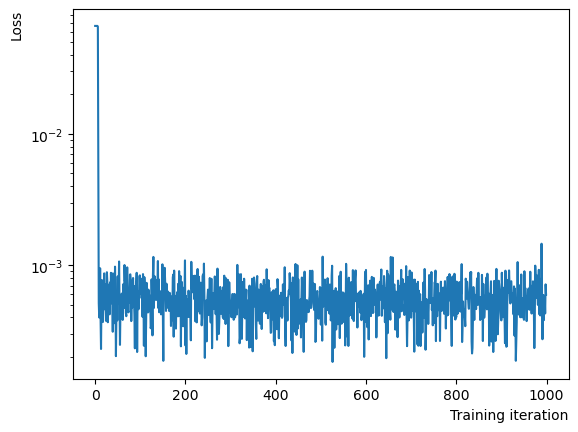

In [21]:
plt.plot(losses)
plt.yscale('log')
plt.xlabel('Training iteration', ha='right', x=1.0)
plt.ylabel('Loss', ha='right', y=1.0)
plt.show()

## Try 2 parameter fit? (lifetime and eField)

In [22]:
#Simulate with defaults: in particular, lifetime == 2200, eField=0.5
sim_default = sim_with_grad()
sim_default.load_detector_properties("../larndsim/detector_properties/module0.yaml",
                             "../larndsim/pixel_layouts/multi_tile_layout-2.2.16.yaml")
target, pix_target = all_sim(sim_default, selected_tracks_torch, selected_tracks.dtype.names, 
                             event_id_map_torch, return_unique_pix=True)

embed_target = embed_adc_list(sim_default, target, pix_target)

<ipython-input-11-bf45e8c64373>:6: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  plane_id = unique_pix[..., 0] // sim.n_pixels[0]


In [23]:
#Setup simulation object for training
sim = sim_with_grad()
sim.load_detector_properties("../larndsim/detector_properties/module0.yaml",
                             "../larndsim/pixel_layouts/multi_tile_layout-2.2.16.yaml")

In [24]:
#Simple MSE loss between target and output
loss_fn = torch.nn.MSELoss()

#Initialize both lifetime and eField to different value
lifetime_init = 1000
eField_init = 0.1
update_grad_param(sim, "lifetime", lifetime_init)
update_grad_param(sim, "eField", eField_init)

# Should be smarter w/ lr, but for now eyeball given gradient
optimizer = torch.optim.SGD([
                             { 'params' : [sim.lifetime], 'lr' : 2e7},
                             { 'params' : [sim.eField], 'lr' : 1}
                            ], momentum=0.01)

training_step_lifetimes = []
training_step_eFields = []
training_step_ADC = []
losses = []

#Training loop
for epoch in range(1000):
    optimizer.zero_grad()
    
    #Simulate with that parameter and get output
    output, pix_out = all_sim(sim, selected_tracks_torch, selected_tracks.dtype.names, event_id_map, 
                              return_unique_pix=True)
    
    embed_output = embed_adc_list(sim, output, pix_out)
    
    #Calc loss between simulated and target + backprop
    loss = loss_fn(embed_output, embed_target)
    loss.backward()
    
    print(sim.lifetime, sim.eField)
    optimizer.step()
    print(sim.lifetime.grad, sim.eField.grad)
    #if epoch % 100 == 0:
    #    print(f"Lifetime for epoch {epoch}, {sim.lifetime} $\\mu s$")
    training_step_lifetimes.append(sim.lifetime.cpu().detach().numpy().copy())
    training_step_eFields.append(sim.eField.cpu().detach().numpy().copy())
    training_step_ADC.append(embed_output.cpu().detach())
    losses.append(loss.cpu().detach())

<ipython-input-11-bf45e8c64373>:6: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  plane_id = unique_pix[..., 0] // sim.n_pixels[0]


tensor(1000., requires_grad=True) tensor(0.1000, requires_grad=True)
tensor(-5.3946e-06) tensor(-0.1195)
tensor(1107.8922, requires_grad=True) tensor(0.2195, requires_grad=True)
tensor(-2.9990e-06) tensor(-0.0216)
tensor(1168.9507, requires_grad=True) tensor(0.2423, requires_grad=True)
tensor(-2.5416e-06) tensor(-0.0170)
tensor(1220.3932, requires_grad=True) tensor(0.2595, requires_grad=True)
tensor(-1.9394e-06) tensor(-0.0126)
tensor(1259.6959, requires_grad=True) tensor(0.2723, requires_grad=True)
tensor(-1.8594e-06) tensor(-0.0118)
tensor(1297.2775, requires_grad=True) tensor(0.2842, requires_grad=True)
tensor(-1.5145e-06) tensor(-0.0094)
tensor(1327.9424, requires_grad=True) tensor(0.2937, requires_grad=True)
tensor(-1.5042e-06) tensor(-0.0092)
tensor(1358.3322, requires_grad=True) tensor(0.3030, requires_grad=True)
tensor(-1.3821e-06) tensor(-0.0084)
tensor(1386.2786, requires_grad=True) tensor(0.3115, requires_grad=True)
tensor(-1.1354e-06) tensor(-0.0068)
tensor(1409.2651, requi

tensor(1916.2460, requires_grad=True) tensor(0.4634, requires_grad=True)
tensor(-1.7331e-07) tensor(-0.0010)
tensor(1919.7374, requires_grad=True) tensor(0.4643, requires_grad=True)
tensor(-1.1646e-07) tensor(-0.0007)
tensor(1922.1016, requires_grad=True) tensor(0.4650, requires_grad=True)
tensor(-1.3230e-07) tensor(-0.0007)
tensor(1924.7712, requires_grad=True) tensor(0.4657, requires_grad=True)
tensor(-6.8137e-08) tensor(-0.0004)
tensor(1926.1606, requires_grad=True) tensor(0.4661, requires_grad=True)
tensor(-9.2017e-08) tensor(-0.0005)
tensor(1928.0149, requires_grad=True) tensor(0.4667, requires_grad=True)
tensor(-8.8222e-08) tensor(-0.0005)
tensor(1929.7979, requires_grad=True) tensor(0.4672, requires_grad=True)
tensor(-1.2533e-07) tensor(-0.0007)
tensor(1932.3224, requires_grad=True) tensor(0.4679, requires_grad=True)
tensor(-1.4248e-07) tensor(-0.0008)
tensor(1935.1971, requires_grad=True) tensor(0.4687, requires_grad=True)
tensor(-2.0034e-07) tensor(-0.0011)
tensor(1939.2327, r

tensor(2032.3209, requires_grad=True) tensor(0.4962, requires_grad=True)
tensor(-2.9646e-08) tensor(-0.0002)
tensor(2032.9135, requires_grad=True) tensor(0.4963, requires_grad=True)
tensor(-8.2045e-08) tensor(-0.0004)
tensor(2034.5603, requires_grad=True) tensor(0.4968, requires_grad=True)
tensor(-1.1718e-07) tensor(-0.0006)
tensor(2036.9204, requires_grad=True) tensor(0.4974, requires_grad=True)
tensor(-4.3803e-08) tensor(-0.0002)
tensor(2037.8201, requires_grad=True) tensor(0.4977, requires_grad=True)
tensor(-2.0472e-08) tensor(-0.0001)
tensor(2038.2385, requires_grad=True) tensor(0.4978, requires_grad=True)
tensor(3.6076e-08) tensor(0.0002)
tensor(2037.5212, requires_grad=True) tensor(0.4976, requires_grad=True)
tensor(-3.6668e-08) tensor(-0.0002)
tensor(2038.2474, requires_grad=True) tensor(0.4979, requires_grad=True)
tensor(-1.0013e-07) tensor(-0.0006)
tensor(2040.2573, requires_grad=True) tensor(0.4984, requires_grad=True)
tensor(-1.1113e-07) tensor(-0.0006)
tensor(2042.5000, req

tensor(2071.1233, requires_grad=True) tensor(0.5078, requires_grad=True)
tensor(-1.7701e-08) tensor(-9.4628e-05)
tensor(2071.4868, requires_grad=True) tensor(0.5079, requires_grad=True)
tensor(-4.4044e-08) tensor(-0.0003)
tensor(2072.3713, requires_grad=True) tensor(0.5082, requires_grad=True)
tensor(-4.7477e-08) tensor(-0.0003)
tensor(2073.3298, requires_grad=True) tensor(0.5084, requires_grad=True)
tensor(-9.2748e-08) tensor(-0.0005)
tensor(2075.1943, requires_grad=True) tensor(0.5090, requires_grad=True)
tensor(-2.3929e-08) tensor(-0.0001)
tensor(2075.6917, requires_grad=True) tensor(0.5091, requires_grad=True)
tensor(-7.1768e-08) tensor(-0.0004)
tensor(2077.1321, requires_grad=True) tensor(0.5095, requires_grad=True)
tensor(-9.0126e-08) tensor(-0.0005)
tensor(2078.9490, requires_grad=True) tensor(0.5100, requires_grad=True)
tensor(1.7349e-08) tensor(7.2926e-05)
tensor(2078.6201, requires_grad=True) tensor(0.5099, requires_grad=True)
tensor(-1.1595e-07) tensor(-0.0006)
tensor(2080.9

tensor(2095.2285, requires_grad=True) tensor(0.5153, requires_grad=True)
tensor(3.4102e-09) tensor(5.0618e-06)
tensor(2095.1631, requires_grad=True) tensor(0.5153, requires_grad=True)
tensor(3.4735e-08) tensor(0.0002)
tensor(2094.4678, requires_grad=True) tensor(0.5151, requires_grad=True)
tensor(7.1755e-08) tensor(0.0004)
tensor(2093.0256, requires_grad=True) tensor(0.5148, requires_grad=True)
tensor(4.3627e-09) tensor(2.7888e-05)
tensor(2092.9241, requires_grad=True) tensor(0.5147, requires_grad=True)
tensor(-2.0678e-08) tensor(-0.0001)
tensor(2093.3367, requires_grad=True) tensor(0.5148, requires_grad=True)
tensor(-1.7067e-08) tensor(-0.0001)
tensor(2093.6821, requires_grad=True) tensor(0.5149, requires_grad=True)
tensor(3.4913e-08) tensor(0.0002)
tensor(2092.9873, requires_grad=True) tensor(0.5148, requires_grad=True)
tensor(-6.7697e-08) tensor(-0.0004)
tensor(2094.3342, requires_grad=True) tensor(0.5152, requires_grad=True)
tensor(-4.4709e-08) tensor(-0.0003)
tensor(2095.2419, req

tensor(2100.7646, requires_grad=True) tensor(0.5178, requires_grad=True)
tensor(-2.1082e-08) tensor(-0.0001)
tensor(2101.1902, requires_grad=True) tensor(0.5180, requires_grad=True)
tensor(5.1131e-08) tensor(0.0003)
tensor(2100.1719, requires_grad=True) tensor(0.5177, requires_grad=True)
tensor(-7.9624e-09) tensor(-5.6138e-05)
tensor(2100.3210, requires_grad=True) tensor(0.5178, requires_grad=True)
tensor(3.0179e-08) tensor(0.0001)
tensor(2099.7190, requires_grad=True) tensor(0.5176, requires_grad=True)
tensor(7.8120e-09) tensor(1.8728e-05)
tensor(2099.5566, requires_grad=True) tensor(0.5176, requires_grad=True)
tensor(2.1357e-08) tensor(9.6057e-05)
tensor(2099.1279, requires_grad=True) tensor(0.5175, requires_grad=True)
tensor(-1.8703e-08) tensor(-0.0001)
tensor(2099.4978, requires_grad=True) tensor(0.5176, requires_grad=True)
tensor(-2.2108e-08) tensor(-0.0001)
tensor(2099.9436, requires_grad=True) tensor(0.5177, requires_grad=True)
tensor(-5.0552e-09) tensor(-4.8089e-05)
tensor(2100

tensor(2110.6218, requires_grad=True) tensor(0.5215, requires_grad=True)
tensor(-2.9013e-08) tensor(-0.0002)
tensor(2111.2021, requires_grad=True) tensor(0.5217, requires_grad=True)
tensor(1.0113e-08) tensor(4.2980e-05)
tensor(2111.0056, requires_grad=True) tensor(0.5217, requires_grad=True)
tensor(-6.1750e-08) tensor(-0.0003)
tensor(2112.2385, requires_grad=True) tensor(0.5220, requires_grad=True)
tensor(-1.6144e-09) tensor(-2.0160e-05)
tensor(2112.2832, requires_grad=True) tensor(0.5220, requires_grad=True)
tensor(-2.9836e-08) tensor(-0.0002)
tensor(2112.8804, requires_grad=True) tensor(0.5222, requires_grad=True)
tensor(2.7673e-09) tensor(-5.0095e-06)
tensor(2112.8311, requires_grad=True) tensor(0.5222, requires_grad=True)
tensor(-9.3996e-08) tensor(-0.0005)
tensor(2114.7104, requires_grad=True) tensor(0.5227, requires_grad=True)
tensor(4.4135e-08) tensor(0.0002)
tensor(2113.8464, requires_grad=True) tensor(0.5225, requires_grad=True)
tensor(-2.1756e-08) tensor(-0.0001)
tensor(2114.

tensor(2107.6399, requires_grad=True) tensor(0.5218, requires_grad=True)
tensor(4.3579e-08) tensor(0.0002)
tensor(2106.7612, requires_grad=True) tensor(0.5215, requires_grad=True)
tensor(2.3619e-08) tensor(0.0001)
tensor(2106.2800, requires_grad=True) tensor(0.5214, requires_grad=True)
tensor(-1.4352e-08) tensor(-9.4863e-05)
tensor(2106.5623, requires_grad=True) tensor(0.5215, requires_grad=True)
tensor(-1.6518e-08) tensor(-0.0001)
tensor(2106.8955, requires_grad=True) tensor(0.5216, requires_grad=True)
tensor(1.0159e-08) tensor(4.0553e-05)
tensor(2106.6956, requires_grad=True) tensor(0.5216, requires_grad=True)
tensor(-2.7314e-09) tensor(-3.8717e-05)
tensor(2106.7483, requires_grad=True) tensor(0.5216, requires_grad=True)
tensor(-4.7375e-08) tensor(-0.0003)
tensor(2107.6963, requires_grad=True) tensor(0.5219, requires_grad=True)
tensor(8.1837e-08) tensor(0.0004)
tensor(2106.0691, requires_grad=True) tensor(0.5215, requires_grad=True)
tensor(-4.5139e-08) tensor(-0.0003)
tensor(2106.955

tensor(2104.1328, requires_grad=True) tensor(0.5218, requires_grad=True)
tensor(-4.9894e-08) tensor(-0.0003)
tensor(2105.1292, requires_grad=True) tensor(0.5221, requires_grad=True)
tensor(-1.1795e-08) tensor(-8.1063e-05)
tensor(2105.3750, requires_grad=True) tensor(0.5222, requires_grad=True)
tensor(-4.0629e-08) tensor(-0.0002)
tensor(2106.1899, requires_grad=True) tensor(0.5224, requires_grad=True)
tensor(-5.0456e-09) tensor(-4.4573e-05)
tensor(2106.2991, requires_grad=True) tensor(0.5225, requires_grad=True)
tensor(-4.3064e-09) tensor(-4.9766e-05)
tensor(2106.3862, requires_grad=True) tensor(0.5225, requires_grad=True)
tensor(7.0686e-08) tensor(0.0003)
tensor(2104.9734, requires_grad=True) tensor(0.5222, requires_grad=True)
tensor(-2.3284e-08) tensor(-0.0001)
tensor(2105.4250, requires_grad=True) tensor(0.5223, requires_grad=True)
tensor(7.3667e-09) tensor(2.5814e-05)
tensor(2105.2822, requires_grad=True) tensor(0.5223, requires_grad=True)
tensor(-3.6266e-08) tensor(-0.0002)
tensor(

tensor(2104.2954, requires_grad=True) tensor(0.5230, requires_grad=True)
tensor(-1.2062e-08) tensor(-7.5366e-05)
tensor(2104.5454, requires_grad=True) tensor(0.5231, requires_grad=True)
tensor(5.7825e-08) tensor(0.0003)
tensor(2103.3914, requires_grad=True) tensor(0.5228, requires_grad=True)
tensor(-2.5266e-08) tensor(-0.0001)
tensor(2103.8853, requires_grad=True) tensor(0.5229, requires_grad=True)
tensor(1.0701e-08) tensor(3.5944e-05)
tensor(2103.6763, requires_grad=True) tensor(0.5229, requires_grad=True)
tensor(4.0684e-08) tensor(0.0002)
tensor(2102.8606, requires_grad=True) tensor(0.5227, requires_grad=True)
tensor(1.8835e-08) tensor(7.7489e-05)
tensor(2102.4758, requires_grad=True) tensor(0.5226, requires_grad=True)
tensor(-6.2515e-08) tensor(-0.0003)
tensor(2103.7222, requires_grad=True) tensor(0.5229, requires_grad=True)
tensor(6.7843e-08) tensor(0.0004)
tensor(2102.3777, requires_grad=True) tensor(0.5226, requires_grad=True)
tensor(-1.8119e-08) tensor(-0.0001)
tensor(2102.7266,

tensor(2095.7417, requires_grad=True) tensor(0.5217, requires_grad=True)
tensor(2.0854e-09) tensor(2.9821e-07)
tensor(2095.7004, requires_grad=True) tensor(0.5217, requires_grad=True)
tensor(5.2612e-08) tensor(0.0003)
tensor(2094.6477, requires_grad=True) tensor(0.5214, requires_grad=True)
tensor(2.7059e-10) tensor(-2.8994e-05)
tensor(2094.6318, requires_grad=True) tensor(0.5215, requires_grad=True)
tensor(-5.0624e-08) tensor(-0.0003)
tensor(2095.6440, requires_grad=True) tensor(0.5217, requires_grad=True)
tensor(1.6921e-08) tensor(6.8969e-05)
tensor(2095.3157, requires_grad=True) tensor(0.5217, requires_grad=True)
tensor(-7.7981e-09) tensor(-5.3163e-05)
tensor(2095.4683, requires_grad=True) tensor(0.5217, requires_grad=True)
tensor(-8.7416e-09) tensor(-6.2395e-05)
tensor(2095.6445, requires_grad=True) tensor(0.5218, requires_grad=True)
tensor(-3.2076e-09) tensor(-4.3523e-05)
tensor(2095.7104, requires_grad=True) tensor(0.5218, requires_grad=True)
tensor(-5.3506e-08) tensor(-0.0003)
te

tensor(2097.9775, requires_grad=True) tensor(0.5234, requires_grad=True)
tensor(-1.0298e-08) tensor(-6.1770e-05)
tensor(2098.1772, requires_grad=True) tensor(0.5235, requires_grad=True)
tensor(-6.4655e-09) tensor(-5.1447e-05)
tensor(2098.3086, requires_grad=True) tensor(0.5235, requires_grad=True)
tensor(1.1875e-08) tensor(5.4955e-05)
tensor(2098.0725, requires_grad=True) tensor(0.5235, requires_grad=True)
tensor(3.1388e-08) tensor(0.0001)
tensor(2097.4424, requires_grad=True) tensor(0.5233, requires_grad=True)
tensor(-4.1622e-08) tensor(-0.0002)
tensor(2098.2686, requires_grad=True) tensor(0.5236, requires_grad=True)
tensor(8.5513e-09) tensor(4.1595e-05)
tensor(2098.1057, requires_grad=True) tensor(0.5235, requires_grad=True)
tensor(2.7087e-08) tensor(0.0001)
tensor(2097.5623, requires_grad=True) tensor(0.5234, requires_grad=True)
tensor(2.4818e-08) tensor(0.0001)
tensor(2097.0605, requires_grad=True) tensor(0.5233, requires_grad=True)
tensor(-2.3257e-08) tensor(-0.0001)
tensor(2097.5

tensor(2091.9675, requires_grad=True) tensor(0.5228, requires_grad=True)
tensor(-3.8448e-09) tensor(-4.4299e-05)
tensor(2092.0454, requires_grad=True) tensor(0.5229, requires_grad=True)
tensor(-5.5164e-09) tensor(-3.6805e-05)
tensor(2092.1565, requires_grad=True) tensor(0.5229, requires_grad=True)
tensor(1.3123e-08) tensor(5.5138e-05)
tensor(2091.8953, requires_grad=True) tensor(0.5228, requires_grad=True)
tensor(-6.7413e-09) tensor(-4.1417e-05)
tensor(2092.0276, requires_grad=True) tensor(0.5229, requires_grad=True)
tensor(-3.6817e-08) tensor(-0.0002)
tensor(2092.7651, requires_grad=True) tensor(0.5231, requires_grad=True)
tensor(4.2332e-08) tensor(0.0002)
tensor(2091.9258, requires_grad=True) tensor(0.5229, requires_grad=True)
tensor(9.2976e-09) tensor(2.8351e-05)
tensor(2091.7314, requires_grad=True) tensor(0.5228, requires_grad=True)
tensor(2.9709e-08) tensor(0.0001)
tensor(2091.1353, requires_grad=True) tensor(0.5227, requires_grad=True)
tensor(4.3008e-08) tensor(0.0002)
tensor(20

tensor(2091.9622, requires_grad=True) tensor(0.5238, requires_grad=True)
tensor(4.0498e-08) tensor(0.0002)
tensor(2091.1567, requires_grad=True) tensor(0.5236, requires_grad=True)
tensor(7.0135e-10) tensor(-8.8914e-06)
tensor(2091.1348, requires_grad=True) tensor(0.5236, requires_grad=True)
tensor(-4.6782e-09) tensor(-4.4302e-05)
tensor(2091.2280, requires_grad=True) tensor(0.5236, requires_grad=True)
tensor(-7.0453e-09) tensor(-5.9546e-05)
tensor(2091.3699, requires_grad=True) tensor(0.5237, requires_grad=True)
tensor(-7.9317e-10) tensor(-2.1837e-05)
tensor(2091.3872, requires_grad=True) tensor(0.5237, requires_grad=True)
tensor(2.0190e-08) tensor(8.9928e-05)
tensor(2090.9836, requires_grad=True) tensor(0.5236, requires_grad=True)
tensor(-7.4602e-08) tensor(-0.0004)
tensor(2092.4717, requires_grad=True) tensor(0.5240, requires_grad=True)
tensor(4.3473e-08) tensor(0.0002)
tensor(2091.6172, requires_grad=True) tensor(0.5238, requires_grad=True)
tensor(-6.4339e-08) tensor(-0.0004)
tensor

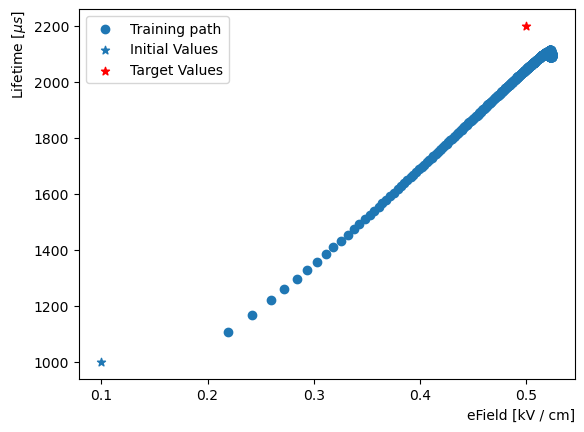

In [25]:
plt.scatter(training_step_eFields, training_step_lifetimes,
        label='Training path')
plt.scatter(eField_init, lifetime_init, c='C0', marker='*', label='Initial Values')
plt.scatter(0.5, 2200, marker='*', c='r', label='Target Values')
plt.xlabel('eField [kV / cm]', x=1.0, ha='right')
plt.ylabel('Lifetime [$\\mu s$]', y=1.0, ha='right')
plt.legend()
plt.show()

Two parameter fit converges to within ~5%

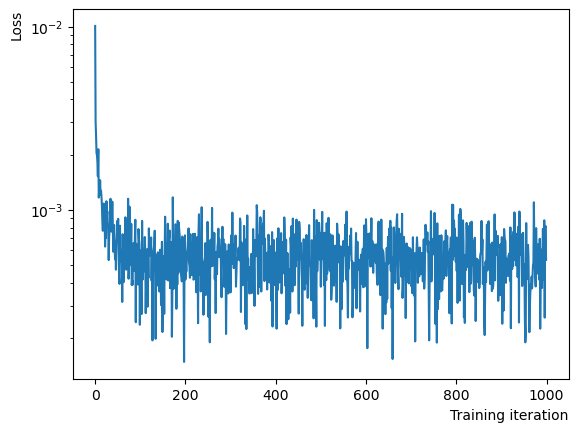

In [26]:
plt.plot(losses)
plt.yscale('log')
plt.xlabel('Training iteration', ha='right', x=1.0)
plt.ylabel('Loss', ha='right', y=1.0)
plt.show()